<img src="https://github.com/Jaimegrp/Practicando/blob/main/Texto/img/cabecera.png?raw=1">

## Una (muy) breve (pero densa) introducción a la IA Generativa en Textos

*NOTA: Este notebook adapta y amplía parte del capítulo dedicado a NLP en el excelente libro [Hands on Machine Learning for Python](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch16.html#nlp_chapter)*

La generación de textos y más que eso el tratamiento de lenguaje natural ha dado un salto "cuántico" en los últimos años dentro del campo de la IA. Vamos a ver de una forma poco ortodoxa la evolución partiendo de las arquitecturas más complejas sobre redes recurrentes hasta terminar en los instruct LLM (la base de la IA multimodal generativa actual). Será un viaje denso y breve, pero espero que despierte el interés en ti para ampliar más con el material extra que se proporciona en la plataforma y en algunos enlaces de este notebook.

*Antes de empezar, este notebook "no" se recomienda si no se ejecuta en un entorno con GPU disponible. Si no es el caso -> Colab:*



<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/Jaimegrp/DS_Online_Oct23/blob/main/05_Deep_Learning/Sprint_21/02_NLP_y_Texto/Generativa_Texto_De_RRN_a_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
from IPython.display import clear_output
from pathlib import Path
from random import random, randint,sample
from time import time, sleep


plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

## Usando RNNs: Una estructura Encoder-Decoder para traducir de inglés a español

El primer gran avance por encima de la vectorización y las técnicas iniciales de resumen (summarization), traducción (translation), preguntas y respuestas (Q&A), es el empleo de redes recurrentes en el tratamiento de textos. Veamos un ejemplo.

El objetivo del siguiente ejemplo es doble:  
1. Mostrar como las redes recurrentes pueden configurarse para tratar un problema de traducción donde a una secuencia de entrada de longitud variable le corresponderá una secuencia de longitud variable y además no necesariamente coincidente, en dicha longitud, con la de entrada. Este problema se aplica a la traducción de inglés a español pero es un esquema que se puede emplear en cualquier tipo de cambio de representación entre secuencias (yes, para pasar de una secuencia a una imagen y viceversa).  

2. Introducir de forma progresiva el concepto de Atention (atención) para mejorar el modelo anterior y sobre este la arquitectura conocida como Transformers, que nos permitirá hablar de GPT, BERT y los LLN (Large Language Models, no Master of Laws, ojo) en general.

### El dataset de entrenamiento

Utilizaremos un datset que empareja palabras y frases en inglés con sus traducciones al español de Tensorflow

In [4]:
import numpy as np
np.random.seed(42)

In [6]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                               extract=True)
text = (Path(path).with_name("spa-eng") / "spa.txt").read_text(encoding = "utf-8")

2638744/2638744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Observamos su contenido (siempre hay que mirar la mercancía antes de ponerse a cocinar)

In [7]:
print(text[:100])

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fueg


In [61]:
text[-4000:]

'or correo electrónico las URL\'s de esas páginas web y ver el contenido en tu computadora cuando llegas a casa.\nA mistake young people often make is to start learning too many languages at the same time, as they underestimate the difficulties and overestimate their own ability to learn them.\tUn error que cometen a menudo los jóvenes es el de comenzar a aprender demasiadas lenguas al mismo tiempo, porque subestiman sus dificultades y sobrestiman sus propias capacidades para aprenderlas.\nNo matter how much you try to convince people that chocolate is vanilla, it\'ll still be chocolate, even though you may manage to convince yourself and a few others that it\'s vanilla.\tNo importa cuánto insistas en convencer a la gente de que el chocolate es vainilla, seguirá siendo chocolate, aunque puede que te convenzas a ti mismo y a algunos otros de que es vainilla.\nIn 1969, Roger Miller recorded a song called "You Don\'t Want My Love." Today, this song is better known as "In the Summer Time."

Lo transformamos para que sea una relación de secuencia a secuencia (dada una secuencia tenemos su target)

In [8]:
import numpy as np

text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)  # separa las parejas en dos listas


Tenemos 118964 sentencias para entrenar
Distribuciones del corpus en inglés
count    118964.000000
mean          6.310363
std           2.611586
min           1.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          47.000000
dtype: float64


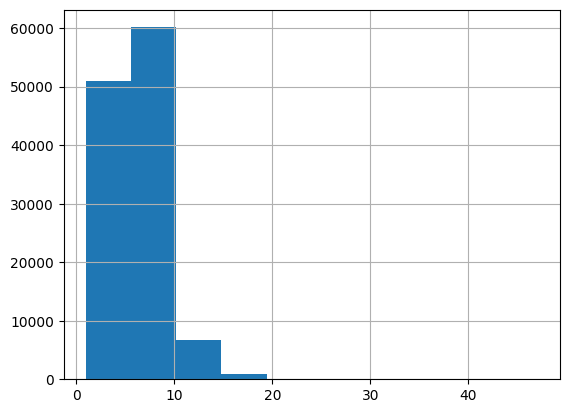

In [9]:
print(f"Tenemos {len(sentences_en)} sentencias para entrenar")
print("Distribuciones del corpus en inglés")
series_en = pd.Series([len(sentencia.split()) for sentencia in sentences_en])
series_en.hist();
print(series_en.describe())

Distribuciones del corpus en español
count    118964.000000
mean          6.083866
std           2.764452
min           1.000000
25%           4.000000
50%           6.000000
75%           7.000000
max          49.000000
dtype: float64


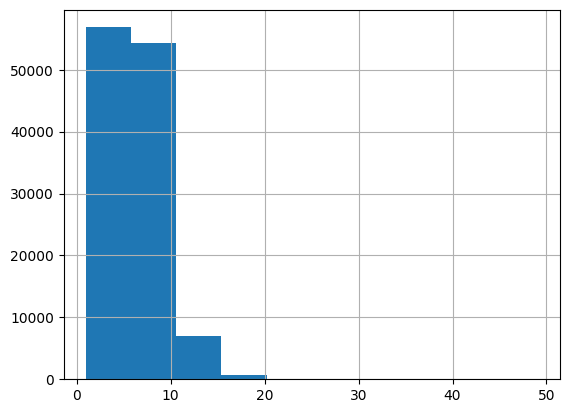

In [10]:
print("Distribuciones del corpus en español")
series_es = pd.Series([len(sentencia.split()) for sentencia in sentences_es])
series_es.hist();
print(series_es.describe())

In [11]:
origen = randint(0,len(sentences_es)-3)
for i in range(origen, origen+3):
    print(f"{sentences_en[i]}({len(sentences_en[i].split())}), '=>', {sentences_es[i]}({len(sentences_es[i].split())})")

She is famous as a singer.(6), '=>', Ella es una cantante famosa.(5)
She is a most gracious neighbor.(6), '=>', Ella es una vecina de lo más amable.(8)
I thought you were going to keep Tom here until I got back.(13), '=>', Pensé que mantendrías a Tom aquí hasta que yo regresara.(10)


### ENCODER-DECODER

Antes de introducir encoder-decoder teníamos este tipo de arquitectura:

![imagen](./data/foto2.png)


Encoder-decoder, ¡tamanño de entrada y de salida distinto!

![imagen](./data/foto3.png)

![imagen](./data/foto4.png)

Cuando return_sequences está a False, la salida es el último estado oculto.

![imagen](./data/foto5.png)

![imagen](./data/foto6.png)

Y, ¿por qué esta arquitectura? Porque antes de que se propusiese no había forma de entrenar modelos que admitiesen secuencias de longitud variable con target otra secuencia de longitud variable (y por tanto pudiendo ser esa longitud diferente a la primera)

El encoder ahora se encarga de convertir cualquier secuencia que haya a la entrada en un vector de longitud fija y el decoder convertira este vector en una secuencia de salida de longitud variable.  

De hecho al encoder le vamos a dar de comer secuencias de longitud fija pero lo suficientemente larga como para que entren todas, y aplicaremos el truco del padding para completar y el de la máscara para que no le afecte a las secuencias cortas.

Entre el encoder y el ecoder se puede pasar el vector repetido o la salida del estado de memoria (otra implementación diferente, como se muestra a continuación).

<img src="https://github.com/Jaimegrp/Practicando/blob/main/Texto/img/encoder_decoder_to_train.jpg?raw=1" alt="Diagram of encoder_decoder" width="600" />

Mejor si lo desenrrollamos:

<img src="img/encoder_decoder_unrolled.jpg" alt="Diagram of encoder_decoder" width="600" />

Veamos como funcionaría (en entrenamiento) [*nota: h y c son los hidden_state de la recurrente del encoder, $h_d$ y $c_d$ son los hidden_state de la recurrente del decoder*]:
1. Al enconder le damos la secuencia [I, like, soccer], y no le va a pasar nada todavía al encoder...
2. Hace el embedding, supongamos que de 2 dimensiones, [ (0.212,-3.32), (1.34, 0.344), (6.665,-4.443)]
3. Procesa la secuencia uno a uno y va transmitiendose el hidden_state ( y la cell_state, es una LSTM) en cada elemento de la secuencia:
    Procesa: e0: [(0.212,-3.32),(0,0,...0),(0,0.....)]
    Procesa: e1: [(1.34,0.344), h([(0.212,-3.32),(0,0,...0),(0,0.....)]),c((0.212,-3.32),(0,0,...0),(0,0.....))] (recordad que las LSTM tienen dos estados ocultos h y c el primero en teoría para la memoria a corto y el segundo para la memoria a largo)
    Procesa: e2 [(6.665, -4.443), h(e1), c(1)]
4. Ahora sí devuelve [salida(e2),h(e2),c(2)] y esto es parte de lo que entra en el Decoder
5. El decoder a la vez ha hecho el embedding de su entrada [emb("\<sos\>"),emb("Me"),emb("gusta"),emb("el"),emb("fútbol")]
5. Lo primero que procesa el decoder es d1: [h(e2),c(e2),emb("\<sos\>")] y la capa de salida predice (en el caso de la figura) "me"  
6. Luego procesa d2: [emb("Me"),$h_d$(d1),$c_d$(d1)] y la capa de salida predice (en este caso): "encanta"
7. procesa d3: [emb("gusta"),$h_d$(d2),$c_d$(d2)] y la capa de salida predice: "el" (Importante, le entra el embedding de la palabra que tendría que haber predicho antes ("gusta") no la que realmente predijo "encanta", esto es *Teaching Forcing*)
8. procesa d4: [emb("el"),$h_d$(d3),$c_d$(d3)] y la capa de salida predice: "fútbol"
9. procesa d5: [emb("fútbol"),$h_d$(d4),$c_d$(4)] y la capa de salida predice: "\<eos\>" (end of sequence) (podría haber hecho la predicción de otra palabra y hubiera acabado igual pero se contabilizaría como un error para el optimizador, etc, etc)
10. Se acaba la secuencia de entrada para el decoder

A destacar:
- El encoder sólo le pasara los hidden_state (h y c) del final de la secuencia de entrada al decoder o un vector repetido.
- El decoder trabaja sobre el target completo desplazado una vez (esto nos sirve para construir el vec2seq), sino, habría que usar TimeDistributed (porque no predecimos solo una palabra).



### Construcción del modelo

Ok, ahora que todo ha quedado clarito como la teoría de la relatividad, vamos a construir el modelo.  
Primero las capas de embeddings: como ya hemos visto primero nuestros vectorizadores para convertir cada sentencia en secuencia de índices y después la capa de embedding para que aprenda cual es la mejor reprensentación de cada índice/palabra en el contexto del problema que estamos resolviendo. (De hecho, ***inciso: ¿qué es lo que realmente está haciendo el encoder...***, *se te ocurre qué podríamos hacer con el encoder una vez entrenado todo el modelo...*)

In [12]:
vocab_size = 1000 # Número de tokens de nuestro vocabulario, en este caso vamos a hacer que token = (conjunto caracteres separados por espacios)
max_length = 50 # Las secuencias de entrada están fijadas a 50, podríamos haberlas fijado a...
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length) # Como no decimos nada split="whitespace", o sea la tokenizacion mencionada
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es]) # Importante le añadimos el comienzo de secuencia y el final para que sepa dónde empieza y para que aprenda cuándo se acaba

In [13]:
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']

In [14]:
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

Veamos cómo codifica algunas de las setencias:

In [15]:
origen = randint(0,len(sentences_es)-3)
for i in range(origen, origen+1):
    print(f"{sentences_en[i]}({len(sentences_en[i].split())}), '=>', {sentences_es[i]}({len(sentences_es[i].split())})")
    print("Vectorizacion sin embedding de la entrada al encoder",text_vec_layer_en(sentences_en[i]), sep = "\n")
    print("Vectorizacion sin embedding de la entrada al decoder", text_vec_layer_es(f"startofseq {sentences_es[i]}"), sep = "\n")
    print("Vectorizacion del target", text_vec_layer_es(f"{sentences_es[i]} endofseq"), sep = "\n")

It snowed yesterday.(3), '=>', Ayer nevó.(2)
Vectorizacion sin embedding de la entrada al encoder
tf.Tensor(
[ 13   1 181   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int64)
Vectorizacion sin embedding de la entrada al decoder
tf.Tensor(
[  2 144   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int64)
Vectorizacion del target
tf.Tensor(
[144   1   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int64)


Construímos los datasets de entrenamiento y validación, teniendo encuenta que encoder y decoder reciben entradas ligeramente diferentes y que el targert debe contener el endofseq (que es un token que debe predecir el modelo, es decir debe predecir cuando acaba la frase)

In [16]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

In [19]:
from keras.layers import RepeatVector

In [23]:
embed_size = 128

# Layer 1 & 2 of Encoder
encoder_inputs     = tf.keras.layers.Input(shape=[], dtype=tf.string)
encoder_input_ids  = text_vec_layer_en(encoder_inputs)
encoder_embeddings = tf.keras.layers.Embedding(vocab_size, embed_size,mask_zero=True)(encoder_input_ids)
encoder = tf.keras.layers.LSTM(512)(encoder_embeddings)
r_vec = RepeatVector(n=max_length)(encoder) # con el repeatVector

# Layer 1 & 2 of Decoder
decoder_inputs     = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_input_ids  = text_vec_layer_es(decoder_inputs)
decoder_embeddings = tf.keras.layers.Embedding(vocab_size, embed_size,mask_zero=True)(decoder_input_ids)
decoder_outputs    = tf.keras.layers.LSTM(512, return_sequences=True, dropout=0.2)(r_vec)

# Layer 3 of Decoder
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(decoder_outputs)

model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None)                 │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 50)             │              0 │ input_layer_3[0][0]    │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 50, 128)        │        128,000 │ text_vectorization[3]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, 50)             │              0 │ text_vectorization[3]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 512)            │      1,312,768 │ embedding_3[0][0],     │
│                           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_2           │ (None, 50, 512)        │              0 │ lstm_3[0][0]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 50, 512)        │      2,099,200 │ repeat_vector_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None)                 │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 50, 1000)       │        513,000 │ lstm_4[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,052,968 (15.46 MB)

 Trainable params: 4,052,968 (15.46 MB)

 Non-trainable params: 0 (0.00 B)

Y ahora sí, comenzamos con la definición (funcional del modelo)

**Warning**: the following cell will take a while to run (possibly a couple hours if you are not using a GPU).

In [24]:
checkpoint_filepath = './tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [25]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [26]:
model.fit((X_train, X_train_dec), Y_train, epochs=100,
          validation_data=((X_valid, X_valid_dec), Y_valid), callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 79s 23ms/step - accuracy: 0.8802 - loss: 0.7074 - val_accuracy: 0.8968 - val_loss: 0.5057
Epoch 2/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 78s 23ms/step - accuracy: 0.8990 - loss: 0.4774 - val_accuracy: 0.9067 - val_loss: 0.4096
Epoch 3/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - accuracy: 0.9085 - loss: 0.3889 - val_accuracy: 0.9111 - val_loss: 0.3699
Epoch 4/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 73s 23ms/step - accuracy: 0.9144 - loss: 0.3443 - val_accuracy: 0.9142 - val_loss: 0.3476
Epoch 5/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 85s 24ms/step - accuracy: 0.9186 - loss: 0.3163 - val_accuracy: 0.9159 - val_loss: 0.3354
Epoch 6/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 79s 24ms/step - accuracy: 0.9215 - loss: 0.2981 - val_accuracy: 0.9169 - val_loss: 0.3301
Epoch 7/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - accuracy: 0.9249 - loss: 0.2783 - val_accuracy: 0.9175 - val_loss: 0.3264
Epoch 8/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 82s 23ms/step - accuracy: 

Una vez entrenado el modelo, la traducción la hacemos palabra por palabra (si no, habría que usar una capa TimeDistributed).  

El decoder espera que le pasemos una secuencia guía (el teacher, aquí no hacemos teacher forcing), que es la función que hacía la secuencia target desplazada uno en el entrenamiento.  

Lo que vamos a hacer es ir prediciendo palabra a palabra introduciendo como guía la última predicción hasta llegar a que el modelo devuelva el carácter de fin de secuencia y en ese momento devolvemos la "traducción"

In [27]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_probs = model.predict((X.astype(object), X_dec.astype(object)))
        y_proba = y_probs[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_proba = round(float(y_proba[predicted_word_id]),3)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
        print(f"{translation}({predicted_proba})")
    return translation.strip()

Probemos con algo sencillo

In [31]:
frase = "I like snow"

In [32]:
translate(frase)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
 me(1.0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
 me gusta(0.67)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
 me gusta la(0.651)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
 me gusta la nieve(0.971)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'me gusta la nieve'

In [62]:
frase= "I like eating cake."

In [69]:
translate(frase)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 me(0.973)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 me gusta(0.906)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
 me gusta comer(0.744)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 me gusta comer torta(0.665)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


'me gusta comer torta'

In [37]:
frase= "The flowers are so beautiful"

In [38]:
translate(frase)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
 las(0.585)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
 las flores(0.819)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
 las flores son(0.538)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
 las flores son muy(0.464)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
 las flores son muy [UNK](0.859)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


'las flores son muy [UNK]'

In [39]:
translate("I like soccer and also going to the beach")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 me(0.995)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
 me gusta(0.829)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
 me gusta [UNK](0.312)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 me gusta [UNK] me(0.3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 me gusta [UNK] me y(0.317)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
 me gusta [UNK] me y me(0.574)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 me gusta [UNK] me y me gusta(0.304)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 me gusta [UNK] me y me gusta la(0.196)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
 me gusta [UNK] me y me gusta la playa(0.79)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


'me gusta [UNK] me y me gusta la playa'

In [45]:
text_vec_layer_en.get_vocabulary()

['',
 '[UNK]',
 'the',
 'i',
 'to',
 'you',
 'tom',
 'a',
 'is',
 'he',
 'in',
 'of',
 'that',
 'it',
 'was',
 'do',
 'have',
 'this',
 'me',
 'my',
 'for',
 'she',
 'dont',
 'are',
 'what',
 'his',
 'mary',
 'we',
 'your',
 'on',
 'be',
 'with',
 'want',
 'not',
 'im',
 'and',
 'like',
 'at',
 'know',
 'him',
 'can',
 'go',
 'her',
 'has',
 'will',
 'its',
 'there',
 'they',
 'time',
 'how',
 'did',
 'as',
 'were',
 'very',
 'had',
 'all',
 'about',
 'here',
 'up',
 'didnt',
 'think',
 'get',
 'out',
 'when',
 'from',
 'cant',
 'if',
 'an',
 'no',
 'one',
 'doesnt',
 'going',
 'by',
 'would',
 'why',
 'come',
 'see',
 'good',
 'ill',
 'please',
 'youre',
 'just',
 'who',
 'been',
 'need',
 'so',
 'more',
 'help',
 'tell',
 'but',
 'now',
 'where',
 'than',
 'never',
 'am',
 'got',
 'too',
 'some',
 'us',
 'something',
 'last',
 'take',
 'much',
 'should',
 'day',
 'ive',
 'car',
 'could',
 'money',
 'home',
 'people',
 'work',
 'well',
 'back',
 'really',
 'our',
 'went',
 'many',
 's

In [46]:
np.in1d("shop", text_vec_layer_en.get_vocabulary())

array([ True])

In [49]:
np.in1d("beautiful", text_vec_layer_en.get_vocabulary())

array([ True])

In [50]:
np.in1d("bonitas", text_vec_layer_es.get_vocabulary())

array([False])

Vamos a ver mejoras que además nos vayan adelantando conceptos para llegar a los LLN

## Bidirectional RNNs

Extra

Una red recurrente bidireccional es la que lee la secuencia tanto de izquierda a derecha como de derecha a izquierda y procesa ambas secuencias en conjunto. Ojo: la secuencia de entrada.

En general es como tener una capa que mira en un sentido y otra en el otro y concatenar luego sus salidas

<img src="img/bidirectionalrnn.jpg" alt="Bidirectional RNN" width="700" />

¿Por qué y para qué? Porque, por ejemplo, hay frases que para traducirlas necesitas ver que viene después, como en el caso de los adjetivos en inglés que anteceden al nombre y de los sinónimos en un idioma que no coinciden necesariamente con los sinónimos en otro: the left arm, the left party, they left the restaurant...


In [64]:
embed_size = 128

# Layer 1 & 2 of Encoder
encoder_inputs     = tf.keras.layers.Input(shape=[], dtype=tf.string)
encoder_input_ids  = text_vec_layer_en(encoder_inputs)
encoder_embeddings = tf.keras.layers.Embedding(vocab_size, embed_size,mask_zero=True)(encoder_input_ids)
encoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256))(encoder_embeddings)
r_vec = RepeatVector(n=max_length)(encoder) # este sí, con el repeatVector funciona

# Layer 1 & 2 of Decoder
decoder_inputs     = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_input_ids  = text_vec_layer_es(decoder_inputs)
decoder_embeddings = tf.keras.layers.Embedding(vocab_size, embed_size,mask_zero=True)(decoder_input_ids)
decoder_outputs    = tf.keras.layers.LSTM(512, return_sequences=True, dropout=0.2)(r_vec)

# Layer 3 of Decoder
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(decoder_outputs)

model_bidirectional = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],outputs=[Y_proba])
model_bidirectional.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model_bidirectional.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None)                 │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 50)             │              0 │ input_layer_5[0][0]    │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 50, 128)        │        128,000 │ text_vectorization[4]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_5 (NotEqual)    │ (None, 50)             │              0 │ text_vectorization[4]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 512)            │        788,480 │ embedding_5[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_3           │ (None, 50, 512)        │              0 │ bidirectional[0][0]    │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 50, 512)        │      2,099,200 │ repeat_vector_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None)                 │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 50, 1000)       │        513,000 │ lstm_6[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,528,680 (13.46 MB)

 Trainable params: 3,528,680 (13.46 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
checkpoint_filepath_bidirectional = './tmp/ckpt/checkpoint.model_bidirectional.keras'
model_checkpoint_callback_bidirectional = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_bidirectional,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [66]:
model_bidirectional.fit((X_train, X_train_dec), Y_train, epochs=100,
          validation_data=((X_valid, X_valid_dec), Y_valid), callbacks=[model_checkpoint_callback_bidirectional, early_stopping_callback])

Epoch 1/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 86s 26ms/step - accuracy: 0.8808 - loss: 0.7063 - val_accuracy: 0.8992 - val_loss: 0.4767
Epoch 2/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 138s 25ms/step - accuracy: 0.9020 - loss: 0.4453 - val_accuracy: 0.9085 - val_loss: 0.3859
Epoch 3/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 78s 24ms/step - accuracy: 0.9106 - loss: 0.3672 - val_accuracy: 0.9120 - val_loss: 0.3547
Epoch 4/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - accuracy: 0.9162 - loss: 0.3281 - val_accuracy: 0.9151 - val_loss: 0.3373
Epoch 5/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 83s 24ms/step - accuracy: 0.9198 - loss: 0.3059 - val_accuracy: 0.9165 - val_loss: 0.3291
Epoch 6/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 81s 24ms/step - accuracy: 0.9223 - loss: 0.2889 - val_accuracy: 0.9174 - val_loss: 0.3256
Epoch 7/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - accuracy: 0.9250 - loss: 0.2739 - val_accuracy: 0.9180 - val_loss: 0.3233
Epoch 8/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - accuracy:

In [70]:
def translate_bidirectional(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_probs = model_bidirectional.predict((X.astype(object), X_dec.astype(object)))
        y_proba = y_probs[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_proba = round(float(y_proba[predicted_word_id]),3)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
        print(f"{translation}({predicted_proba})")
    return translation.strip()

Para crear un capa recurrente bidireccional, se hace lo siguiente (encapsular una recurrente en una más genérica denominada Bidirectional)

En el caso del decoder no podemos hacer lo mismo porque en el target mirar al futuro sí es hacer trampa (recordemos que hasta ahora le pasamos la palabra que correspondería a la palabra esperada anterior, o sea no hacemos trampa), y por tanto no serviría para predecir algo que no hubiera visto (de hecho no podríamos construir una entrada para predecir de forma correcta)

Pero, la recurrente bidireccional produce el doble de estados ocultos. Como se trata de una lstm tendremos dos hidden_state y dos cell_state, aunque el decoder sólo espera dos (porque es otra LSTM)

In [97]:
translate_bidirectional("I want to read an old book.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 quiero(0.659)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 quiero leer(0.441)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 quiero leer un(0.483)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 quiero leer un libro(0.798)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 quiero leer un libro libro(0.495)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 quiero leer un libro libro libro(0.83)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 quiero leer un libro libro libro (0.755)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 quiero leer un libro libro libro  (0.997)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
 quiero leer un libro libro libro   (1.0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
 quiero leer un libro libro libro    (1.0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
 quiero leer un libro libro libro     (1.0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 quiero leer un libro libro libro      (1.0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
 quiero leer un libro libro libro       (1.0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
 

'quiero leer un libro libro libro'

In [103]:
translate("I want to read an old book.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
 quiero(0.995)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
 quiero leer(0.833)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
 quiero leer un(0.531)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
 quiero leer un libro(0.815)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
 quiero leer un libro libro(0.985)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


'quiero leer un libro libro'

## Beam Search

This is a very basic implementation of beam search. I tried to make it readable and understandable, but it's definitely not optimized for speed! The function first uses the model to find the top _k_ words to start the translations (where _k_ is the beam width). For each of the top _k_ translations, it evaluates the conditional probabilities of all possible words it could add to that translation. These extended translations and their probabilities are added to the list of candidates. Once we've gone through all top _k_ translations and all words that could complete them, we keep only the top _k_ candidates with the highest probability, and we iterate over and over until they all finish with an EOS token. The top translation is then returned (after removing its EOS token).

* Note: If p(S) is the probability of sentence S, and p(W|S) is the conditional probability of the word W given that the translation starts with S, then the probability of the sentence S' = concat(S, W) is p(S') = p(S) * p(W|S). As we add more words, the probability gets smaller and smaller. To avoid the risk of it getting too small, which could cause floating point precision errors, the function keeps track of log probabilities instead of probabilities: recall that log(a\*b) = log(a) + log(b), therefore log(p(S')) = log(p(S)) + log(p(W|S)).

In [6]:
# extra code – a basic implementation of beam search

def beam_search(sentence_en, beam_width, verbose=False):
    X = np.array([sentence_en])  # encoder input
    X_dec = np.array(["startofseq"])  # decoder input
    y_proba = model.predict((X.astype(object), X_dec.astype(object)))[0, 0]  # first token's probas
    top_k = tf.math.top_k(y_proba, k=beam_width)
    top_translations = [  # list of best (log_proba, translation)
        (np.log(word_proba), text_vec_layer_es.get_vocabulary()[word_id])
        for word_proba, word_id in zip(top_k.values, top_k.indices)
    ]

    # extra code – displays the top first words in verbose mode
    if verbose:
        print("Top first words:", top_translations)

    for idx in range(1, max_length):
        candidates = []
        for log_proba, translation in top_translations:
            if translation.endswith("endofseq"):
                candidates.append((log_proba, translation))
                continue  # translation is finished, so don't try to extend it
            X = np.array([sentence_en])  # encoder input
            X_dec = np.array(["startofseq " + translation])  # decoder input
            y_proba = model.predict((X.astype(object), X_dec.astype(object)))[0, idx]  # last token's proba
            for word_id, word_proba in enumerate(y_proba):
                word = text_vec_layer_es.get_vocabulary()[word_id]
                candidates.append((log_proba + np.log(word_proba),
                                   f"{translation} {word}"))
        top_translations = sorted(candidates, reverse=True)[:beam_width]

        # extra code – displays the top translation so far in verbose mode
        if verbose:
            print("Top translations so far:", top_translations)

        if all([tr.endswith("endofseq") for _, tr in top_translations]):
            return top_translations[0][1].replace("endofseq", "").strip()

In [107]:
# extra code – shows how the model making an error
sentence_en = "I love cats and dogs"
translate(sentence_en)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 me(0.292)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 me gustan(0.711)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 me gustan los(0.98)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 me gustan los los(0.981)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 me gustan los los gatos(0.608)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 me gustan los los gatos los(0.717)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'me gustan los los gatos los'

The correct translation is in the top 3 sentences found by beam search, but it's not the first. Since we're using a small vocabulary, the \[UNK] token is quite frequent, so you may want to penalize it (e.g., divide its probability by 2 in the beam search function): this will discourage beam search from using it too much.

## Mecanismos de Atencion (Attention mechanisms)

Como mejora a este tipo de arquitecturas, en 2014 (Dzmitry Bahdanau y colegas, et al. que se dice) introdujeron una mejora sustancial a la arquitectura de Encoder-Decoders.

La idea detrás del mecanismo es pasarle al decoder más información de la secuencia de entrada y no sólo los estados ocultos producidos por el último elemento (el primero y el úlitmo en el caso de bidireccionales). ¿Qué información? Pues algo así como la palabra que más le aporte en cada momento. Por ejemplo que cuando al decoder le toque producir fútbol en la traducción de I like soccer, reciba "soccer" (en concreto la salida del enconder a la palabra "soccer").  

Supongamos que estamos traduciendo frases como:

I like soccer  
I like Rain Man  
you like The Bridge  
we like Marta  
  
Para los dos primeras el decoder iría traduciendo:
(Me) gusta ... y la idea es que las entradas "soccer", "Rain" + "Man", "The" + "Bridge", "Marta" aporten más en ese instante...  

Entonces al decoder tendré que pasarle todas las palabras de la frase (en concreto la salida de cada una de estas del encoder) y que exista un mecanismo que le diga en función de lo que lleva cuál de las entradas debe considerar más (aquí nos fijamos en la siguiente, pero para traducir "Me" es mejor que se fije en la primera, el pronombre, para traducir "gusta", igual)  

Lo interesante no es considerar solo una palabra de entrada, sino una combinación pesada de estas (una combinación lineal -> "The" + "Bridge")

Es decir, volviendo a nuestras entradas del decoder:

* Antes d1: [h(e2),c(2),emb("<start_of_sequence>")], ahora da1 (la a es de attention): [h(e2),c(e2), (coef1 * e1 + coef2 * e2 + coef3 * e3)] y probablemente todos los coef se aproximarían a cero
* Antes d2: [emb("Me"),$h_d$(d1),$c_d$(d1)], ahora da2: [emb("Me"),$h_d$(d1),$c_d$(d1), (coef21 * e1 + coef22 * e2 + coef23 * e3)] y probablemente coef21 >> coef22 y coef23
* Antes d3: [emb("gusta"),$h_d$(d2),$c_d$(d2)], ahora da3: [emb("gusta"),$h_d$(d1),$c_d$(d1), (coef31 * e1 + coef32 * e2 + coef33 * e3) ] y coef31 y coef32 serán altos y coef33 bajo o nulo


__¿Y cómo le digo en cuál debe fijarse más? Pues como en los embeddings... que lo aprenda :-) (o sea tendré una Attention Layer)__


Muy bien, y cómo se hace ese "que lo aprenda": Dos mecanismos de Atencion (aditiva y multiplicativa), pero el multiplicativo ha superado al aditivo y de hecho la Attention Layer de keras hace Attention multiplicativa y además al final la predicción se hace a partir de la salida de la capa de atención.

Gráficamente:

<img src="https://github.com/Jaimegrp/Practicando/blob/main/Texto/img/encoder_decoder_with_attention.jpg?raw=1" alt="Encoder_Decoder with Attention" width="700" />


Intuitivamente al poner la capa de atención al final está configurando toda la red (toda incluidos los embeddings) para que "memorice" la relación estadística entre las posiciones de salida y las de entrada en diferentes situaciones. Y luego ya nosotros a eso le llamamos atención, porque es verdad que cuando llega el momento de "Me gusta el...", ha memorizado que las posiciones que deben aportar más es donde haya salidas que generalmente pertenecen a nombres. (pero él ni sabe que son nombres, ni que está traduciendo ni nada,...)


El siguiente paso sería aumentar la memoria y olvidarse de las recurrencias (y del problema de traducir) :-)... los Transformers, pero antes... prestémosle Atención al traductor con atención

And finally, let's add the `Attention` layer and the output layer:

## Y sí, la solución es simple y llanamente establecer relacion los elementos de la secuencia entre sí.... ***Attention Is All You Need: The Transformer Architecture***


Y en 2017, alguien de una empresa..., publicó un paper en el que se presentaba en sociedad una arquitectura que sólo necesitaba de mecanismos de Atenttion y capas Densas para hacer NMT como el mejor.

OJO, esta sección es a título ilustrativo... Pero molón.
Si quieres saber más cuando tengas más tiempo, te recomiendo esta referencia [https://kikaben.com/transformers-encoder-decoder/].

<img src="https://github.com/Jaimegrp/Practicando/blob/main/Texto/img/transformers.webp?raw=1" alt="Encoder_Decoder with Attention" width="700" />



Antes de asustarse, lo que realmente hace esta arquitectura es ser las superconvolucional con memoria de las secuencias de texto... Vamos por partes:

__La parte del encoder__ al incluir el mecanismo de atención (y ese positional encoding) lo que está haciendo es aprender las relaciones posicionales de las palabras del "lenguaje" de entrada (sí está memorizando y caracterizando las relaciones entre todas las palabras y sus posiciones de entrada), está haciendo un embedding de la información posicional. Luego concatena la información posicional con la de entrada y aprende a relacionarla lo mejor posible para esa secuencia. En tiempo de inferencia diríamos que para cada secuencia está analizandola sintácticamente, gramaticalmente, etc, etc y luego la devuelve... Pero nunca le hemos pasado información ni sintáctica, ni gramatical, ni nada.

__La parte del decoder__ primero hace lo mismo que el encoder pero con el "lenguaje" de destino, se aprende y caracteriza todas las relaciones posicionales de las sentencias de ese "lenguaje". Combina ese embedding por secuencia con la secuencia de destino y se lo pasa a la siguiente capa de atención que ahora memoriza y caracteriza todas las relaciones posicionales entre las sentencias procesadas y enriquecidas del lenguaje destino y las sentencias procesadas y enriquecidas del lenguaje de origen. Y luego el feedfoward es el que realmente mezcla todo (mezclará toda la información de la secuencia, vease que se va transmitiendo, las posiciones y las posiciones con el lenguaje origen).

Para aumentar la memoria y dar más relaciones lo que hacemos es que la capa de atención en realidad son muchas capas de atención en paralelo y acumular modulos de atención (como acumulábamos capas convolucionales en una red convolucional)

A título ilustrativo un __capa multihead de atención__:

<img src="https://github.com/Jaimegrp/Practicando/blob/main/Texto/img/multihead_attention.png?raw=1" alt="Multihead Attention Layer" width="700" />

Las capas linear son capas densas sin función de activación, tienen pesos entrenables -> Memoria (en estos pesos está la memoria de las características posicionales)
Y las capas head fuerzan que las linear (tantas como cabezas*3) aprendan un número de relaciones "poscionales" que dependen del número de cabezas (si quiero que apredan más relaciones posicionales -> Más cabezas)



Y para terminar hay N modulos (en el paper de 2017, 6 por Encoder y 6 por Decoder) apilados, ¿por qué? Aquí una idea intuitiva es la misma que en las convolucionales, para que pueda memorizar relaciones posicionales más complicadas (y tener más memoria entrenable).

## Large Language Models (Pretrained Transformers)

Y en 2018, llegaron las arquitecturas que apilaban multihead attention layers pero ya olvidándose de decoders y encoders... Una sola columna con muchos módulos... pero con la magia de estar pre-entrenadas para una tarea (generalmente adivina cuál es la siguiente palabra de la sentencia (GPT) o de cada sentencia te voy a ocultar 2 palabras, adivina cuales son (BERT)).

En esencia, están memorizando todas las relaciones que existen entre las palabras de un lenguaje... Por eso cada vez se hacen más grandes (para memorizar más) y tienen más parámetros... y necesitan más que les des de comer (si quieres tenerlo todo representado)... (Imagina que le pudieras dar para entrenar a un red convolucional todas las imágenes posibles que existen)

<img src="https://github.com/Jaimegrp/Practicando/blob/main/Texto/img/gpt2_vs_BERT.jpg?raw=1" alt="Multihead Attention Layer" width="800" />

Luego estos modelos preentrenados se adaptan (fine-tunning), o sea, se hace transfer learning, a otros tipos de problemas (clasificación, sentiment analysis, question and answers, y ahora chats, texto generativo).





## Instruct LLM

Hoy en día, lo que realmente se ha puesto "de moda" no es emplear los LLM como los vistos hasta ahora, sino los fine-tuned y más concretamente los basados en una aproximación denominada "Instruct LLM" (partiendo de un paper de OpenAI):

<img src="https://github.com/Jaimegrp/Practicando/blob/main/Texto/img/rlhf.jpg?raw=1" alt="Instruct LLM" width="800" />

Han surgido decenas de modelos, propietarios y abiertos, los más destacados (que puedes usar):  
[OpenAI, ChatGPT](https://chat.openai.com/)  
[Google, Gemini](https://gemini.google.com/?hl=es)  
[Mistral, Mistral MoE](https://mistral.ai/)  
[Meta, Llama-2](https://ai.meta.com/blog/5-steps-to-getting-started-with-llama-2/)  
[Hugging Face, miles y miles de modelos](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard)  
[Preplexity AI, integra GPT-4 y Claude (no accesible directamente en España](https://www.perplexity.ai/)

### Curiosidades y simlitudes

Veamos algunas cosas curiosas:


In [ ]:
import pyperclip

In [ ]:
prompt = "Dame una lista de los siete mejores arquitectos de la historia o por lo menos de los más famosos y dame un ejemplo de sus mejores obras o de las más conocidas" #@param {type:"string"}

In [ ]:
new_prompt = []
for token in prompt.split():
  new_token = ""
  if len(token) > 3:
    new_token = token[0:2] + token[3:]
  else:
    new_token = token
  new_prompt.append(new_token)
print(" ".join(new_prompt))

In [ ]:
new_prompt = prompt.split()[::-1]
print(" ".join(new_prompt))